In [ ]:
# Dataset:
    # Simulated engine degradation under different combinations of operational conditions and modes 
    # Records several sensor channels to characterize fault evolution. Provided by NASA
    # https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/
# Approach:
    # Prognostics: predicting the time at which something will no longer perform it's indended function
    # Remaining Useful Life (RUL): continious target, number of useful cycles left on the engine
    # A next step is to spend time feature engineering
    # A next step would be to use LSTM and GPU neural networks

In [1]:
#Loading Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

# Loading Dataset

In [2]:
dataset_train=pd.read_csv('PM_train.txt',sep=' ',header=None).drop([26,27],axis=1)
col_names = ['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
dataset_train.columns=col_names
print('Shape of Train dataset: ',dataset_train.shape)
dataset_train.head()

Shape of Train dataset:  (20631, 26)


id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60   
1   1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14   
2   1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99  1404.20   
3   1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79  1401.87   
4   1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85  1406.22   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20      s21  
0  39.06  23.4190  
1  39.00  23.4236  
2  38.95  23.3442  
3  38.88  23.3739  
4  38.90  23.4044  

[5 rows x 26 columns]

In [3]:
dataset_test=pd.read_csv('PM_test.txt',sep=' ',header=None).drop([26,27],axis=1)
dataset_test.columns=col_names

print('Shape of Test dataset: ',dataset_train.shape)
dataset_train.head()

Shape of Test dataset:  (20631, 26)


id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60   
1   1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14   
2   1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99  1404.20   
3   1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79  1401.87   
4   1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85  1406.22   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20      s21  
0  39.06  23.4190  
1  39.00  23.4236  
2  38.95  23.3442  
3  38.88  23.3739  
4  38.90  23.4044  

[5 rows x 26 columns]

# Loading Truth table

In [4]:
pm_truth=pd.read_csv('PM_truth.txt',sep=' ',header=None).drop([1],axis=1)
pm_truth.columns=['more']
pm_truth['id']=pm_truth.index+1
pm_truth.head()

more  id
0   112   1
1    98   2
2    69   3
3    82   4
4    91   5

In [5]:
# generate column max for test data
rul = pd.DataFrame(dataset_test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul.head()

id  max
0   1   31
1   2   49
2   3  126
3   4  106
4   5   98

In [6]:
# run to failure
pm_truth['rtf']=pm_truth['more']+rul['max']
pm_truth.head()

more  id  rtf
0   112   1  143
1    98   2  147
2    69   3  195
3    82   4  188
4    91   5  189

In [7]:
pm_truth.drop('more', axis=1, inplace=True)
dataset_test=dataset_test.merge(pm_truth,on=['id'],how='left')
dataset_test['RUL']=dataset_test['rtf'] - dataset_test['cycle']
dataset_test.drop('rtf', axis=1, inplace=True)
dataset_test.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1    0.0023    0.0003     100.0  518.67  643.02  1585.29  1398.21   
1   1      2   -0.0027   -0.0003     100.0  518.67  641.71  1588.45  1395.42   
2   1      3    0.0003    0.0001     100.0  518.67  642.46  1586.94  1401.34   
3   1      4    0.0042    0.0000     100.0  518.67  642.44  1584.12  1406.42   
4   1      5    0.0014    0.0000     100.0  518.67  642.51  1587.19  1401.92   

      s5  ...      s13      s14     s15   s16  s17   s18    s19    s20  \
0  14.62  ...  2388.03  8125.55  8.4052  0.03  392  2388  100.0  38.86   
1  14.62  ...  2388.06  8139.62  8.3803  0.03  393  2388  100.0  39.02   
2  14.62  ...  2388.03  8130.10  8.4441  0.03  393  2388  100.0  39.08   
3  14.62  ...  2388.05  8132.90  8.3917  0.03  391  2388  100.0  39.00   
4  14.62  ...  2388.03  8129.54  8.4031  0.03  390  2388  100.0  38.99   

       s21  RUL  
0  23.3735  142  
1  23.3916  141  
2  23.4166  140  
3  23.3737  139  
4  23.4130  138  

[5 rows x 27 columns]

In [8]:
dataset_train['RUL'] = dataset_train.groupby(['id'])['cycle'].transform(max)-dataset_train['cycle']
dataset_train.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60   
1   1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14   
2   1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99  1404.20   
3   1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79  1401.87   
4   1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85  1406.22   

      s5  ...      s13      s14     s15   s16  s17   s18    s19    s20  \
0  14.62  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06   
1  14.62  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00   
2  14.62  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95   
3  14.62  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88   
4  14.62  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90   

       s21  RUL  
0  23.4190  191  
1  23.4236  190  
2  23.3442  189  
3  23.3739  188  
4  23.4044  187  

[5 rows x 27 columns]

C:\Users\Negin Service\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:1209: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


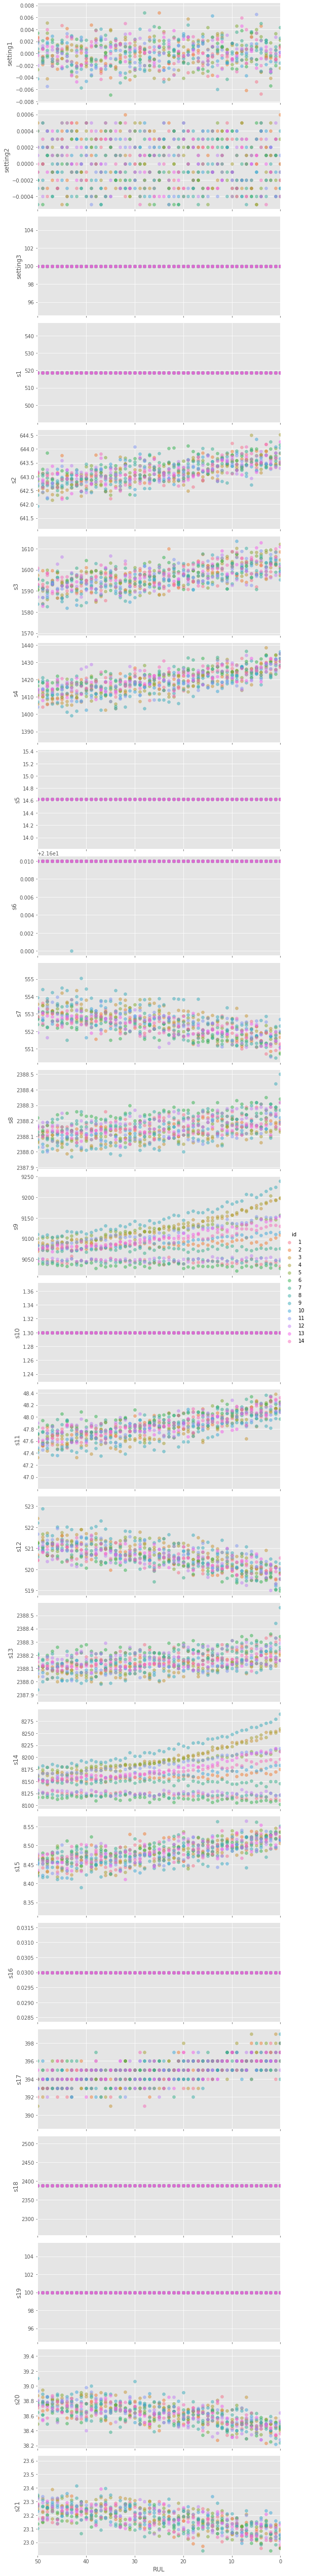

In [9]:
# use seaborn to visualize features to target (RUL)
target_var = ['RUL']
col_names = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
explore = sns.PairGrid(data= dataset_train.query('id < 15') ,
                 x_vars=target_var,
                 y_vars=col_names,
                 hue="id", size=3, aspect=2.5)
explore = explore.map(plt.scatter, alpha=0.5)
explore = explore.set(xlim=(50,0))
explore = explore.add_legend()

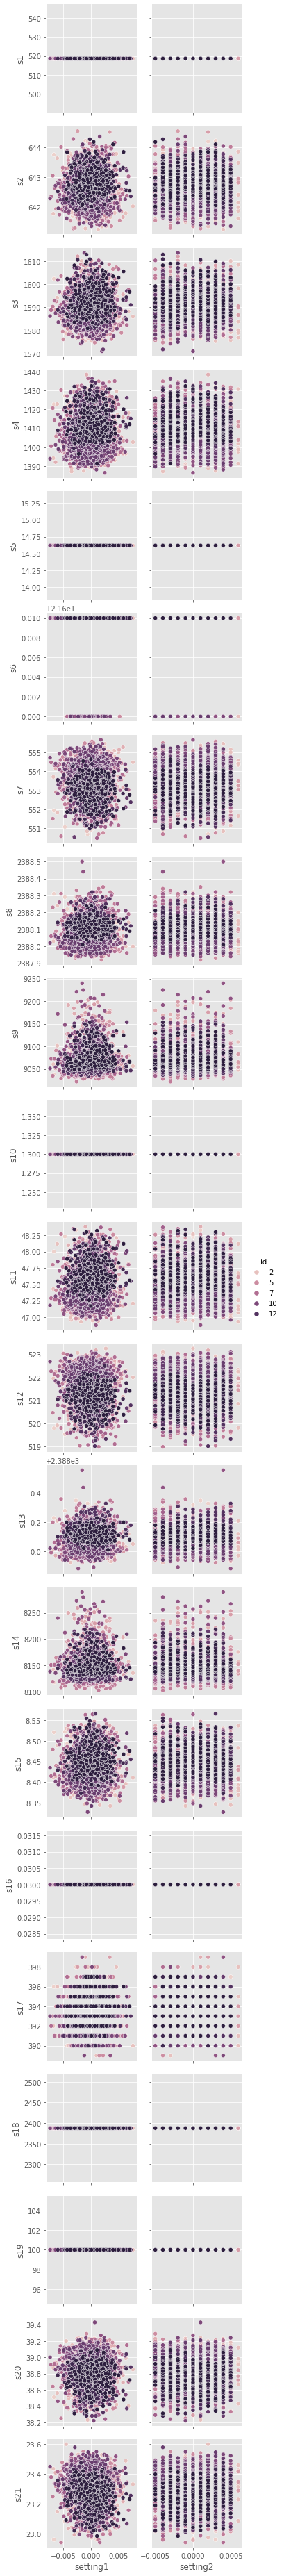

In [10]:
# operational setting 3 is stable, let's visualize op setting 1 and 2 against some of the most active sensors
g = sns.pairplot(data=dataset_train.query('id < 15'),
                 x_vars=["setting1","setting2"],
                 y_vars=['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21'],
                 hue="id", aspect=1)

In [11]:
# now it's time to clear out target dataset_train 
print(dataset_train.shape)
leakage_to_drop = ['id', 'cycle', 'setting3']  
train_no_leakage = dataset_train.drop(leakage_to_drop, axis = 1)
print(train_no_leakage.shape)
# set up features and target variable 
y_train = train_no_leakage['RUL']
X_train = train_no_leakage.drop(['RUL'], axis = 1)

(20631, 27)
(20631, 24)


In [12]:
# now it's time to clear out target leakage leakagedataset_test
print(dataset_test.shape)
leakage_to_drop = ['id', 'cycle', 'setting3']  
test_no_leakage = dataset_test.drop(leakage_to_drop, axis = 1)
print(test_no_leakage.shape)
# set up features and target variable 
y_test = test_no_leakage['RUL']
X_test = test_no_leakage.drop(['RUL'], axis = 1)

(13096, 27)
(13096, 24)


In [13]:
# I like to use a simple random forest to determine some of the most important/meaningful features. Can be used as feature selection
# create an exhuastive random forest (200 trees up to 15 levels deep)
from sklearn import ensemble
rf = ensemble.RandomForestRegressor()
single_rf = ensemble.RandomForestRegressor(n_estimators = 200, max_depth = 15)
single_rf.fit(X_train, y_train)
y_pred = single_rf.predict(X_train)
print("complete")

complete


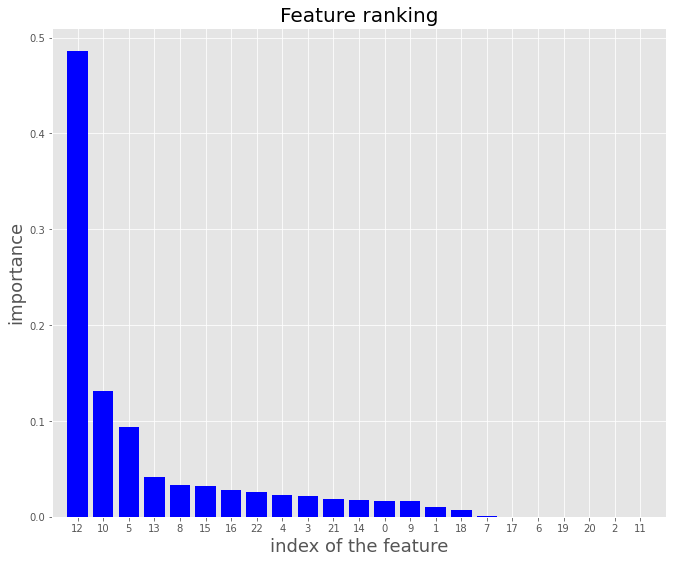

s11    0.486082
s9     0.130792
s4     0.093438
s12    0.041062
s7     0.032754
s14    0.032072
s15    0.027438
s21    0.025613
s3     0.022637
s2     0.021526
dtype: float64


In [14]:
# graph feature importance
import matplotlib.pyplot as plt
importances = single_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns    
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X_train.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X_train.shape[1]), indices) #feature_names, rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()
# list feature importance
important_features = pd.Series(data=single_rf.feature_importances_,index=X_train.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features.head(10))

In [15]:
train_no_leakage.to_csv("DEl.csv")

In [16]:
# based on the graphs as well as random forest feature importance, I will exclude sensors without much valuable information dataset_train
print(train_no_leakage.shape)
vars_to_drop = ["s"+str(i) for i in [6, 16, 5, 18, 19, 1, 10]]
train_final = train_no_leakage.drop(vars_to_drop, axis = 1)
print(train_final.shape)

(20631, 24)
(20631, 17)


In [17]:
#dataset_test
print(test_no_leakage.shape)
vars_to_drop = ["s"+str(i) for i in [6, 16, 5, 18, 19, 1, 10]]
test_final = test_no_leakage.drop(vars_to_drop, axis = 1)
print(test_final.shape)

(13096, 24)
(13096, 17)


In [18]:
test_final

setting1  setting2      s2       s3       s4      s7       s8       s9  \
0        0.0023    0.0003  643.02  1585.29  1398.21  553.90  2388.04  9050.17   
1       -0.0027   -0.0003  641.71  1588.45  1395.42  554.85  2388.01  9054.42   
2        0.0003    0.0001  642.46  1586.94  1401.34  554.11  2388.05  9056.96   
3        0.0042    0.0000  642.44  1584.12  1406.42  554.07  2388.03  9045.29   
4        0.0014    0.0000  642.51  1587.19  1401.92  554.16  2388.01  9044.55   
...         ...       ...     ...      ...      ...     ...      ...      ...   
13091    0.0049    0.0000  643.24  1599.45  1415.79  553.41  2388.02  9142.37   
13092   -0.0011   -0.0001  643.22  1595.69  1422.05  553.22  2388.05  9140.68   
13093   -0.0006   -0.0003  643.44  1593.15  1406.82  553.04  2388.11  9146.81   
13094   -0.0038    0.0001  643.26  1594.99  1419.36  553.37  2388.07  9148.85   
13095    0.0013    0.0003  642.95  1601.62  1424.99  552.48  2388.06  9155.03   

         s11     s12      s13      s14     s15  s17    s20      s21  RUL  
0      47.20  521.72  2388.03  8125.55  8.4052  392  38.86  23.3735  142  
1      47.50  522.16  2388.06  8139.62  8.3803  393  39.02  23.3916  141  
2      47.50  521.97  2388.03  8130.10  8.4441  393  39.08  23.4166  140  
3      47.28  521.38  2388.05  8132.90  8.3917  391  39.00  23.3737  139  
4      47.31  522.15  2388.03  8129.54  8.4031  390  38.99  23.4130  138  
...      ...     ...      ...      ...     ...  ...    ...      ...  ...  
13091  47.69  520.69  2388.00  8213.28  8.4715  394  38.65  23.1974   24  
13092  47.60  521.05  2388.09  8210.85  8.4512  395  38.57  23.2771   23  
13093  47.57  521.18  2388.04  8217.24  8.4569  395  38.62  23.2051   22  
13094  47.61  521.33  2388.08  8220.48  8.4711  395  38.66  23.2699   21  
13095  47.80  521.07  2388.05  8214.64  8.4903  396  38.70  23.1855   20  

[13096 rows x 17 columns]

# Multivariate Time Series Forecasting with Multiple_Timesteps LSTMs in Keras

In [19]:
from pandas import DataFrame
from pandas import concat
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow import keras
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)

In [20]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [21]:
train_final_name =train_final.columns
train_final_name

Index(['setting1', 'setting2', 's2', 's3', 's4', 's7', 's8', 's9', 's11',
       's12', 's13', 's14', 's15', 's17', 's20', 's21', 'RUL'],
      dtype='object')

In [22]:
train_final_name = train_final_name.drop("RUL")
train_final_name

Index(['setting1', 'setting2', 's2', 's3', 's4', 's7', 's8', 's9', 's11',
       's12', 's13', 's14', 's15', 's17', 's20', 's21'],
      dtype='object')

# Feature Scaling

In [23]:
sc_train=MinMaxScaler()
train_final[train_final_name]=sc_train.fit_transform(train_final[train_final_name])
train_final

setting1  setting2        s2        s3        s4        s7        s8  \
0      0.459770  0.166667  0.183735  0.406802  0.309757  0.726248  0.242424   
1      0.609195  0.250000  0.283133  0.453019  0.352633  0.628019  0.212121   
2      0.252874  0.750000  0.343373  0.369523  0.370527  0.710145  0.272727   
3      0.540230  0.500000  0.343373  0.256159  0.331195  0.740741  0.318182   
4      0.390805  0.333333  0.349398  0.257467  0.404625  0.668277  0.242424   
...         ...       ...       ...       ...       ...       ...       ...   
20626  0.477011  0.250000  0.686747  0.587312  0.782917  0.254428  0.439394   
20627  0.408046  0.083333  0.701807  0.729453  0.866475  0.162641  0.500000   
20628  0.522989  0.500000  0.665663  0.684979  0.775321  0.175523  0.515152   
20629  0.436782  0.750000  0.608434  0.746021  0.747468  0.133655  0.530303   
20630  0.316092  0.083333  0.795181  0.639634  0.842167  0.151369  0.545455   

             s9       s11       s12       s13       s14       s15       s17  \
0      0.109755  0.369048  0.633262  0.205882  0.199608  0.363986  0.333333   
1      0.100242  0.380952  0.765458  0.279412  0.162813  0.411312  0.333333   
2      0.140043  0.250000  0.795309  0.220588  0.171793  0.357445  0.166667   
3      0.124518  0.166667  0.889126  0.294118  0.174889  0.166603  0.333333   
4      0.149960  0.255952  0.746269  0.235294  0.174734  0.402078  0.416667   
...         ...       ...       ...       ...       ...       ...       ...   
20626  0.196491  0.726190  0.170576  0.558824  0.194344  0.656791  0.750000   
20627  0.194651  0.708333  0.211087  0.500000  0.188668  0.727203  0.583333   
20628  0.198196  0.738095  0.281450  0.529412  0.212148  0.922278  0.833333   
20629  0.233285  0.916667  0.208955  0.514706  0.203065  0.823394  0.583333   
20630  0.178363  0.803571  0.130064  0.558824  0.192951  0.687572  0.666667   

            s20       s21  RUL  
0      0.713178  0.724662  191  
1      0.666667  0.731014  190  
2      0.627907  0.621375  189  
3      0.573643  0.662386  188  
4      0.589147  0.704502  187  
...         ...       ...  ...  
20626  0.271318  0.109500    4  
20627  0.124031  0.366197    3  
20628  0.232558  0.053991    2  
20629  0.116279  0.234466    1  
20630  0.178295  0.218172    0  

[20631 rows x 17 columns]

In [24]:
sc_test=MinMaxScaler()
test_final[train_final_name]=sc_test.fit_transform(test_final[train_final_name])

In [25]:
test_final

setting1  setting2        s2        s3        s4        s7        s8  \
0       0.65625  0.692308  0.596215  0.421968  0.282214  0.608871  0.365854   
1       0.34375  0.230769  0.182965  0.504025  0.225240  0.800403  0.292683   
2       0.53125  0.538462  0.419558  0.464814  0.346130  0.651210  0.390244   
3       0.77500  0.461538  0.413249  0.391587  0.449867  0.643145  0.341463   
4       0.60000  0.461538  0.435331  0.471306  0.357974  0.661290  0.292683   
...         ...       ...       ...       ...       ...       ...       ...   
13091   0.81875  0.461538  0.665615  0.789665  0.641209  0.510081  0.317073   
13092   0.44375  0.384615  0.659306  0.692028  0.769042  0.471774  0.390244   
13093   0.47500  0.230769  0.728707  0.626071  0.458036  0.435484  0.536585   
13094   0.27500  0.538462  0.671924  0.673851  0.714111  0.502016  0.439024   
13095   0.59375  0.692308  0.574132  0.846014  0.829079  0.322581  0.414634   

             s9       s11       s12       s13       s14       s15    s17  \
0      0.196475  0.273973  0.534247  0.325581  0.152259  0.347076  0.375   
1      0.229042  0.479452  0.634703  0.395349  0.277907  0.227709  0.500   
2      0.248506  0.479452  0.591324  0.325581  0.192892  0.533557  0.500   
3      0.159080  0.328767  0.456621  0.372093  0.217896  0.282359  0.250   
4      0.153410  0.349315  0.632420  0.325581  0.187891  0.337009  0.125   
...         ...       ...       ...       ...       ...       ...    ...   
13091  0.902989  0.609589  0.299087  0.255814  0.935703  0.664909  0.625   
13092  0.890038  0.547945  0.381279  0.465116  0.914003  0.567593  0.750   
13093  0.937011  0.527397  0.410959  0.348837  0.971066  0.594919  0.750   
13094  0.952644  0.554795  0.445205  0.441860  1.000000  0.662991  0.750   
13095  1.000000  0.684932  0.385845  0.372093  0.947848  0.755034  0.875   

            s20       s21  RUL  
0      0.500000  0.620099  142  
1      0.645455  0.645718  141  
2      0.700000  0.681104  140  
3      0.627273  0.620382  139  
4      0.618182  0.676008  138  
...         ...       ...  ...  
13091  0.309091  0.370842   24  
13092  0.236364  0.483652   23  
13093  0.281818  0.381741   22  
13094  0.318182  0.473461   21  
13095  0.354545  0.353999   20  

[13096 rows x 17 columns]

In [26]:
cols_change_train = train_final.columns
cols_change_test = test_final.columns.tolist()

In [27]:
cols_change_train =[
 'RUL', 'setting1',
 'setting2',
 's2',
 's3',
 's4',
 's7',
 's8',
 's9',
 's11',
 's12',
 's13',
 's14',
 's15',
 's17',
 's20',
 's21']

In [28]:
train_final = train_final[cols_change_train]
test_final = test_final[cols_change_train]

In [29]:
test_final

RUL  setting1  setting2        s2        s3        s4        s7  \
0      142   0.65625  0.692308  0.596215  0.421968  0.282214  0.608871   
1      141   0.34375  0.230769  0.182965  0.504025  0.225240  0.800403   
2      140   0.53125  0.538462  0.419558  0.464814  0.346130  0.651210   
3      139   0.77500  0.461538  0.413249  0.391587  0.449867  0.643145   
4      138   0.60000  0.461538  0.435331  0.471306  0.357974  0.661290   
...    ...       ...       ...       ...       ...       ...       ...   
13091   24   0.81875  0.461538  0.665615  0.789665  0.641209  0.510081   
13092   23   0.44375  0.384615  0.659306  0.692028  0.769042  0.471774   
13093   22   0.47500  0.230769  0.728707  0.626071  0.458036  0.435484   
13094   21   0.27500  0.538462  0.671924  0.673851  0.714111  0.502016   
13095   20   0.59375  0.692308  0.574132  0.846014  0.829079  0.322581   

             s8        s9       s11       s12       s13       s14       s15  \
0      0.365854  0.196475  0.273973  0.534247  0.325581  0.152259  0.347076   
1      0.292683  0.229042  0.479452  0.634703  0.395349  0.277907  0.227709   
2      0.390244  0.248506  0.479452  0.591324  0.325581  0.192892  0.533557   
3      0.341463  0.159080  0.328767  0.456621  0.372093  0.217896  0.282359   
4      0.292683  0.153410  0.349315  0.632420  0.325581  0.187891  0.337009   
...         ...       ...       ...       ...       ...       ...       ...   
13091  0.317073  0.902989  0.609589  0.299087  0.255814  0.935703  0.664909   
13092  0.390244  0.890038  0.547945  0.381279  0.465116  0.914003  0.567593   
13093  0.536585  0.937011  0.527397  0.410959  0.348837  0.971066  0.594919   
13094  0.439024  0.952644  0.554795  0.445205  0.441860  1.000000  0.662991   
13095  0.414634  1.000000  0.684932  0.385845  0.372093  0.947848  0.755034   

         s17       s20       s21  
0      0.375  0.500000  0.620099  
1      0.500  0.645455  0.645718  
2      0.500  0.700000  0.681104  
3      0.250  0.627273  0.620382  
4      0.125  0.618182  0.676008  
...      ...       ...       ...  
13091  0.625  0.309091  0.370842  
13092  0.750  0.236364  0.483652  
13093  0.750  0.281818  0.381741  
13094  0.750  0.318182  0.473461  
13095  0.875  0.354545  0.353999  

[13096 rows x 17 columns]

# LSTM Network

In [30]:
# specify the number of lag hours
n_priod =10
n_features = 17

In [31]:
reframed_train = series_to_supervised(train_final, n_priod, 1)
print(reframed_train.shape)

(20621, 187)


In [32]:
reframed_test = series_to_supervised(test_final, n_priod, 1)
print(reframed_test.shape)

(13086, 187)


In [33]:
values_train = reframed_train.values
values_test = reframed_test.values

In [34]:
# split into input and outputs
n_obs = n_priod * n_features
train_X, train_y = values_train[:, :n_obs], values_train[:, -n_features]
test_X, test_y = values_test[:, :n_obs], values_test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(20621, 170) 20621 (20621,)


In [35]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_priod, n_features))
test_X = test_X.reshape((test_X.shape[0], n_priod, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(20621, 10, 17) (20621,) (13086, 10, 17) (13086,)


In [36]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

Epoch 1/55
287/287 - 7s - loss: 92.9339 - val_loss: 116.4097
Epoch 2/55
287/287 - 4s - loss: 78.5522 - val_loss: 102.5762
Epoch 3/55
287/287 - 4s - loss: 67.6722 - val_loss: 90.1857
Epoch 4/55
287/287 - 4s - loss: 58.4993 - val_loss: 79.0654
Epoch 5/55
287/287 - 5s - loss: 50.5139 - val_loss: 69.0953
Epoch 6/55
287/287 - 4s - loss: 43.7047 - val_loss: 60.0972
Epoch 7/55
287/287 - 4s - loss: 38.2798 - val_loss: 51.9830
Epoch 8/55
287/287 - 4s - loss: 33.2451 - val_loss: 45.2756
Epoch 9/55
287/287 - 4s - loss: 28.9726 - val_loss: 39.1987
Epoch 10/55
287/287 - 4s - loss: 25.4961 - val_loss: 33.7626
Epoch 11/55
287/287 - 4s - loss: 23.2620 - val_loss: 29.1854
Epoch 12/55
287/287 - 4s - loss: 20.2745 - val_loss: 26.0814
Epoch 13/55
287/287 - 4s - loss: 18.3699 - val_loss: 22.5547
Epoch 14/55
287/287 - 4s - loss: 16.5780 - val_loss: 20.3292
Epoch 15/55
287/287 - 4s - loss: 15.6818 - val_loss: 18.2228
Epoch 16/55
287/287 - 4s - loss: 14.5412 - val_loss: 16.0672
Epoch 17/55
287/287 - 4s - loss

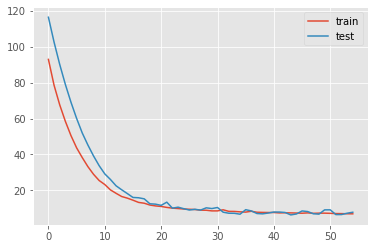

In [37]:
# fit network
history = model.fit(train_X, train_y, epochs=55, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [38]:
def LSTM_RUL_RMSE(machine_id):
    machine_df=dataset_test[dataset_test.id==machine_id]
    leakage_to_drop = ['id', 'cycle', 'setting3']  
    test_no_leakage = machine_df.drop(leakage_to_drop, axis = 1)
    vars_to_drop = ["s"+str(i) for i in [6, 16, 5, 18, 19, 1, 10]]
    test_final = test_no_leakage.drop(vars_to_drop, axis = 1)
    test_final_name =test_final.columns
    test_final_name = test_final_name.drop("RUL")
    sc_test=MinMaxScaler()
    test_final[train_final_name]=sc_test.fit_transform(test_final[test_final_name]) 
    cols_change_test = test_final.columns.tolist()
    cols_change_test =['RUL', 'setting1', 'setting2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17','s20','s21']
    test_final = test_final[cols_change_test]
    # specify the number of lag hours
    n_priod =10
    n_features = 17
    reframed_test = series_to_supervised(test_final, n_priod, 1)
    values_test = reframed_test.values
    # split into input and outputs
    n_obs = n_priod * n_features
    test_X, test_y = values_test[:, :n_obs], values_test[:, -n_features]
    test_X = test_X.reshape((test_X.shape[0], n_priod, n_features))
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_priod*n_features))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, -16:]), axis=1)
    inv_yhat = inv_yhat[:,0]
    RUL_prid = inv_yhat[-1]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -16:]), axis=1)
    inv_y = inv_y[:,0]
    RUL_truth = inv_y[-1]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    return RUL_prid, RUL_truth , rmse

In [41]:
LSTM_RUL_RMSE(85)

(117.29545593261719, 118.0, 3.378876573022456)

In [61]:
RUL_prid_LSTM =list()
for i in range(1,101):
    RUL_prid_LSTM.append(LSTM_RUL_RMSE(machine_id = i))

In [62]:
RUL_prid_LSTM = DataFrame(RUL_prid_LSTM,columns=['RUL_prid_LSTM', "RUL_truth_LSTM", "rmse_LSTM"] )
RUL_prid_LSTM.index += 1
RUL_prid_LSTM

RUL_prid_LSTM  RUL_truth_LSTM  rmse_LSTM
1       103.780945           112.0   4.802101
2        92.337029            98.0   4.732113
3        64.632843            69.0   4.591190
4        74.077690            82.0   5.760494
5        87.297249            91.0   4.457391
6        90.439026            93.0   4.111419
7        84.165039            91.0   4.406688
8        87.788490            95.0   9.175953
9       107.074677           111.0   2.440413
10       91.631042            96.0   9.472886
11       90.484718            97.0   5.342483
12      117.936989           124.0  26.192837
13       87.645111            95.0  10.613665
14      100.908394           107.0   4.917001
15       76.554451            83.0   5.350514
16       79.701797            84.0   4.833058
17       45.555744            50.0   3.193226
18       25.586823            28.0   4.040163
19       77.878120            87.0   5.760270
20       13.562622            16.0   3.445869
21       53.347683            57.0   3.231260
22      107.297188           111.0   2.599932
23      107.804955           113.0   5.757096
24       16.785038            20.0   3.027167
25      138.302475           145.0   4.270417
26      113.387871           119.0   3.587688
27       61.363945            66.0   4.656729
28       90.045700            97.0   5.394044
29       84.054489            90.0   7.281210
30      107.432472           115.0   7.840704
31        5.966270             8.0   3.970144
32       44.157722            48.0   3.617868
33       99.137154           106.0   5.383125
34        5.495711             7.0   3.559652
35        8.885074            11.0   3.348195
36       16.281202            19.0   3.962867
37       18.275169            21.0   4.608276
38       45.412399            50.0   4.629176
39      141.873947           142.0   4.052272
40       23.349667            28.0   3.873371
41       15.501660            18.0   4.103652
42        8.579914            10.0   2.889210
43       53.328377            59.0   4.516603
44      106.572296           109.0   2.156963
45      109.862198           114.0   7.508495
46       42.195942            47.0   3.355437
47      131.655579           135.0   3.828944
48       85.980530            92.0   5.448090
49       18.544716            21.0  16.020958
50       72.622452            79.0   6.006360
51      108.492455           114.0   7.131163
52       25.411209            29.0   4.163898
53       23.303284            26.0   2.935762
54       90.820221            97.0   4.276478
55      129.042511           137.0   5.410972
56       13.229753            15.0   4.550719
57       98.547836           103.0   6.982824
58       32.436943            37.0   4.136359
59      108.225494           114.0   4.095863
60       94.883644           100.0   5.910298
61       18.175207            21.0   2.645110
62       50.254910            54.0   7.764419
63       68.605492            72.0   4.744307
64       24.870415            28.0   3.839509
65      122.824471           128.0   4.475831
66       12.157210            14.0   2.309861
67       72.226685            77.0   4.085011
68        6.174356             8.0   2.662558
69      116.883476           121.0   5.100517
70       87.118652            94.0   5.334837
71      111.007607           118.0   4.980084
72       44.643543            50.0   5.273577
73      124.853554           131.0   5.676207
74      121.817329           126.0   7.116881
75      110.685135           113.0   3.209576
76        7.733833            10.0   3.075338
77       30.780399            34.0   3.350599
78       99.270050           107.0   4.388469
79       60.695011            63.0   3.579265
80       83.770538            90.0   4.904295
81        6.485217             8.0   3.031006
82        7.761314             9.0   3.789229
83      131.029327           137.0   4.035526
84       54.858261            58.0   3.996793
85      116.066154           118.0   4.320642
86       84.702629            89.0   4.626957
87 

In [63]:
RUL_prid_LSTM.to_csv("RUL_prid_LSTM.csv")

# Predicting Remaining useful time by LSTM

In [374]:
def LSTM_RUL_RMSE(machine_id):
    machine_df=dataset_test[dataset_test.id==machine_id]
    leakage_to_drop = ['id', 'cycle', 'setting3']  
    test_no_leakage = machine_df.drop(leakage_to_drop, axis = 1)
    vars_to_drop = ["s"+str(i) for i in [6, 16, 5, 18, 19, 1, 10]]
    test_final = test_no_leakage.drop(vars_to_drop, axis = 1)
    test_final_name =test_final.columns
    test_final_name = test_final_name.drop("RUL")
    sc_test=MinMaxScaler()
    test_final[train_final_name]=sc_test.fit_transform(test_final[test_final_name]) 
    cols_change_test = test_final.columns.tolist()
    cols_change_test =['RUL', 'setting1', 'setting2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17','s20','s21']
    test_final = test_final[cols_change_test]
    # specify the number of lag hours
    n_priod =10
    n_features = 17
    reframed_test = series_to_supervised(test_final, n_priod, 1)
    values_test = reframed_test.values
    # split into input and outputs
    n_obs = n_priod * n_features
    test_X, test_y = values_test[:, :n_obs], values_test[:, -n_features]
    test_X = test_X.reshape((test_X.shape[0], n_priod, n_features))
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_priod*n_features))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, -16:]), axis=1)
    RUL_prid = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -16:]), axis=1)
    RUL_truth = inv_y[:,0]
    return RUL_prid, RUL_truth

In [375]:
LSTM_RUL_RMSE(2)

(array([136.62313843, 135.65878296, 133.71224976, 133.01626587,
        132.06442261, 130.51306152, 128.91275024, 128.82443237,
        129.28536987, 126.94615173, 123.93386841, 122.72891998,
        121.72286987, 119.9283371 , 118.20240021, 117.34000397,
        118.66899872, 117.60436249, 115.81176758, 115.82902527,
        113.90189362, 112.20133209, 110.20317841, 109.61960602,
        109.1730957 , 108.35007477, 108.42729187, 107.19243622,
        105.50541687, 104.35545349, 102.44583893, 102.32581329,
        102.92416382, 101.90065002,  99.88557434,  98.01248169,
         97.81757355,  97.11543274,  94.7520752 ]),
 array([136., 135., 134., 133., 132., 131., 130., 129., 128., 127., 126.,
        125., 124., 123., 122., 121., 120., 119., 118., 117., 116., 115.,
        114., 113., 112., 111., 110., 109., 108., 107., 106., 105., 104.,
        103., 102., 101., 100.,  99.,  98.]))

In [376]:
def LSTM_Plot(machine_id):
    RUL_prid, inv_real = LSTM_RUL_RMSE_Plot(machine_id)
    plt.plot(inv_real, label='Real')
    plt.plot(inv_prid, label='Predict')
    plt.xlabel('Day')
    plt.ylabel('RUL')
    plt.title(machine_id)
    plt.legend()
    plt.show()
    plt.show()
    return

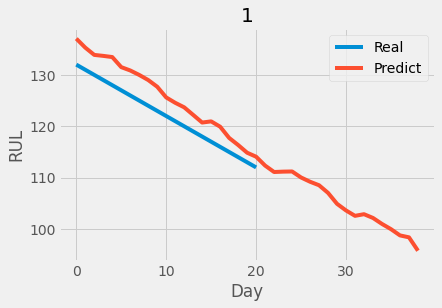

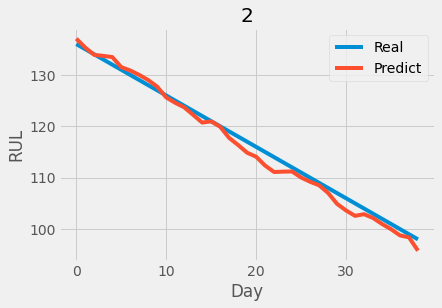

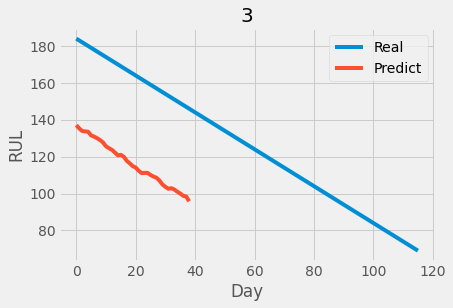

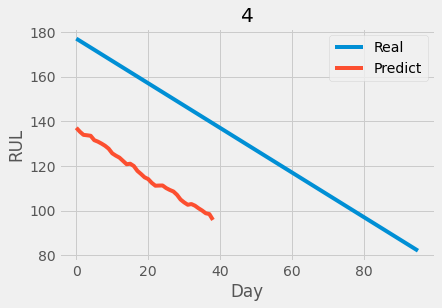

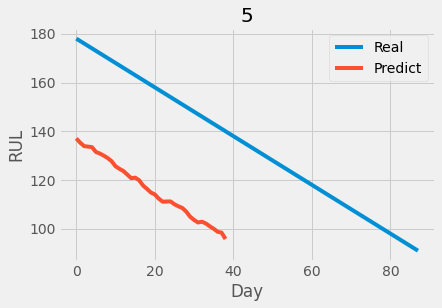

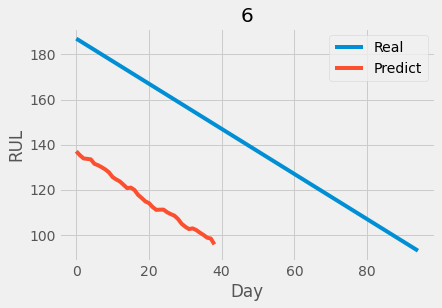

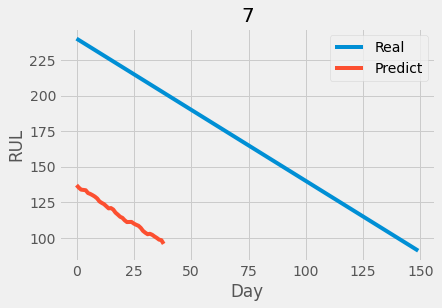

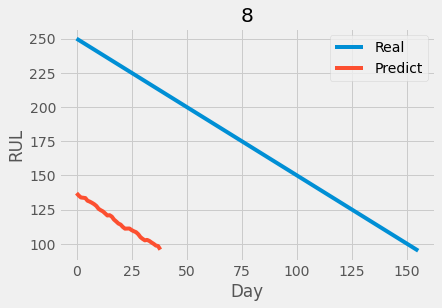

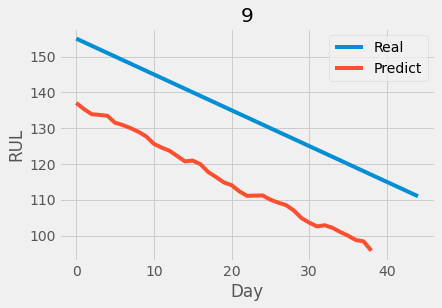

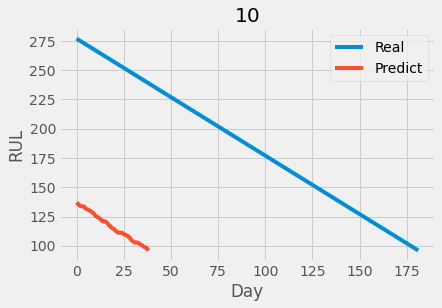

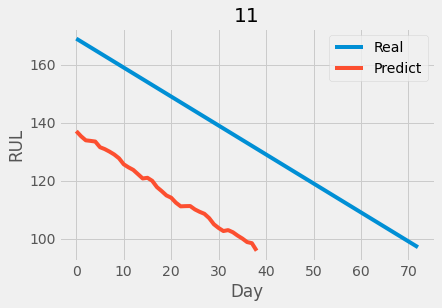

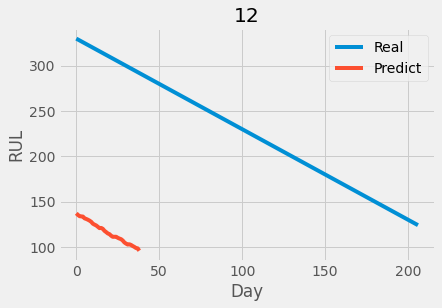

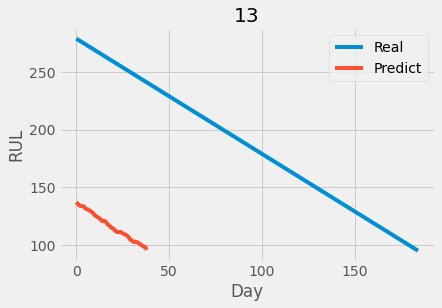

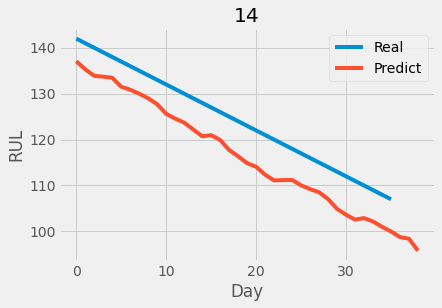

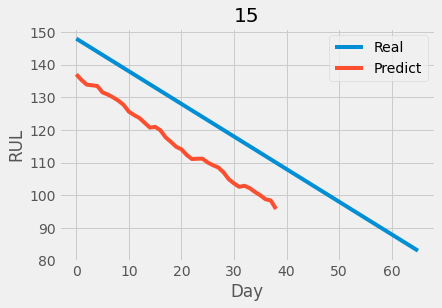

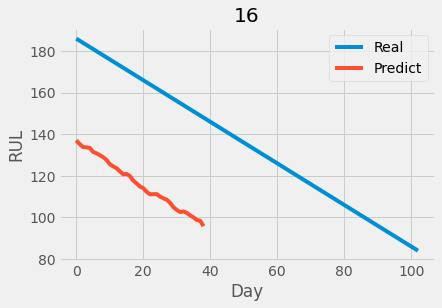

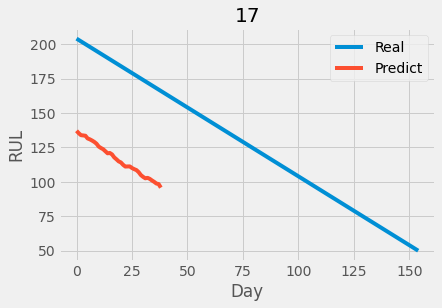

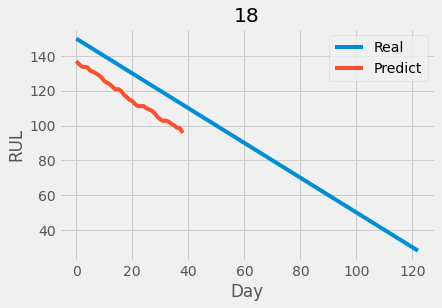

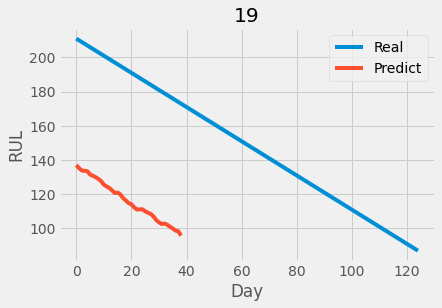

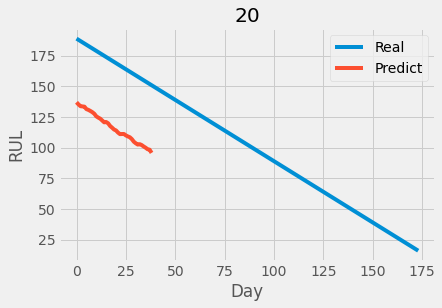

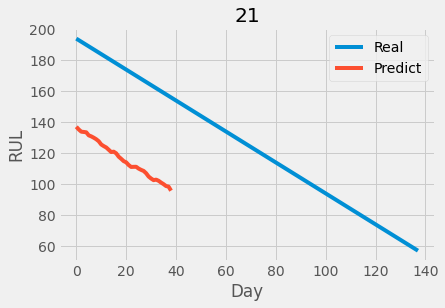

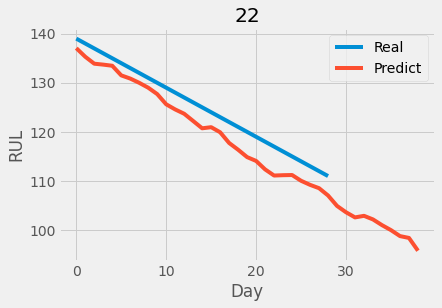

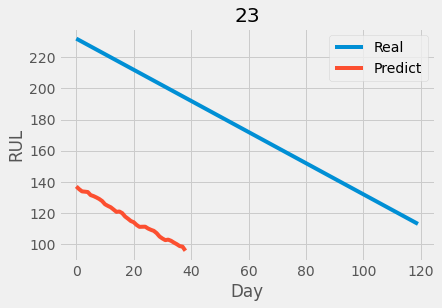

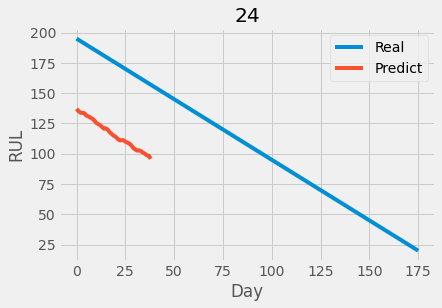

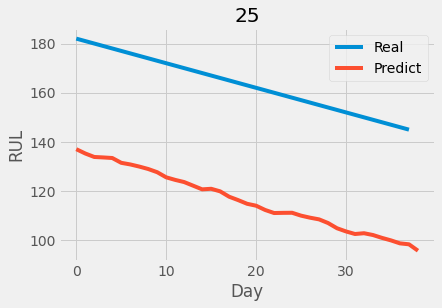

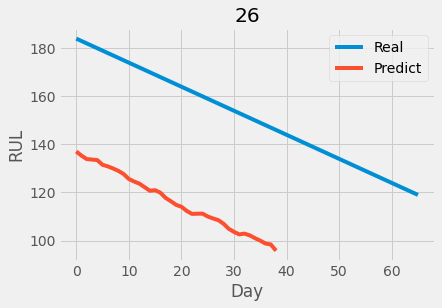

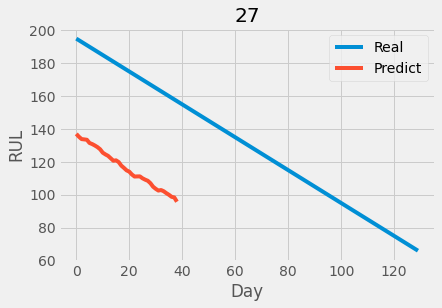

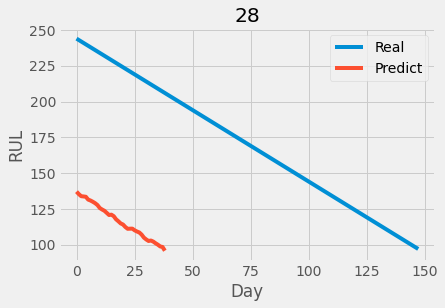

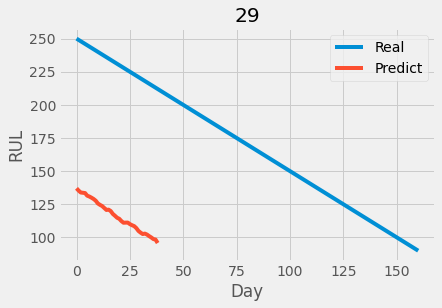

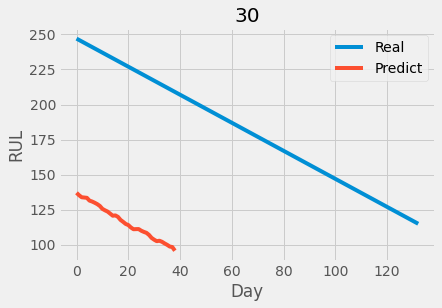

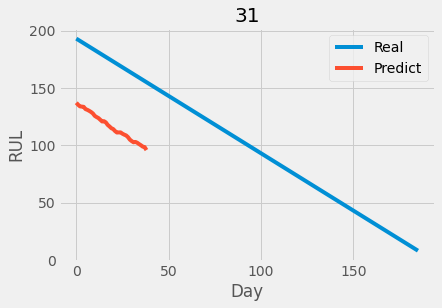

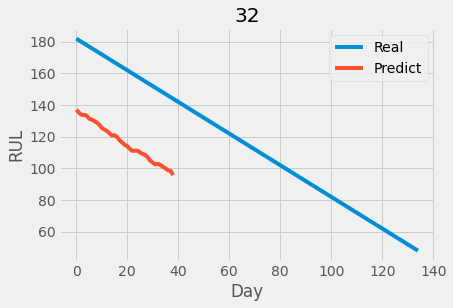

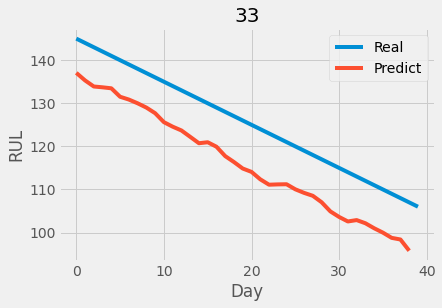

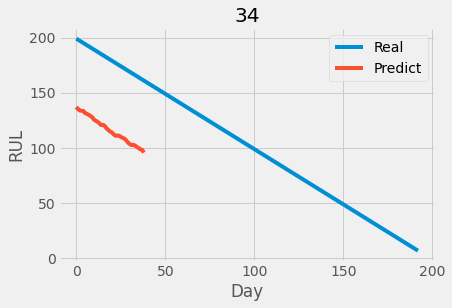

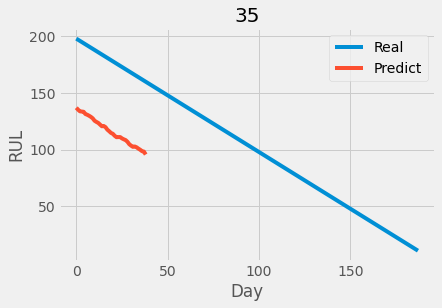

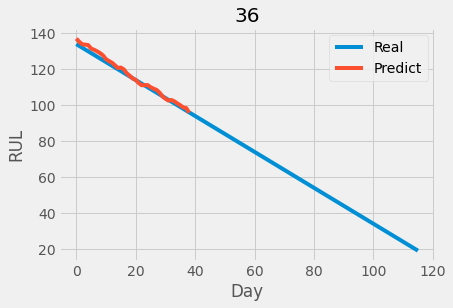

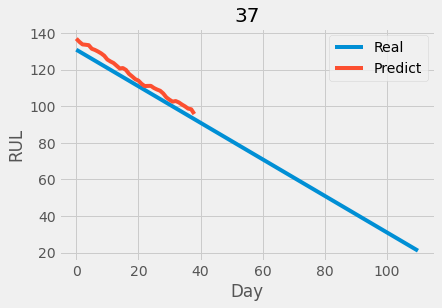

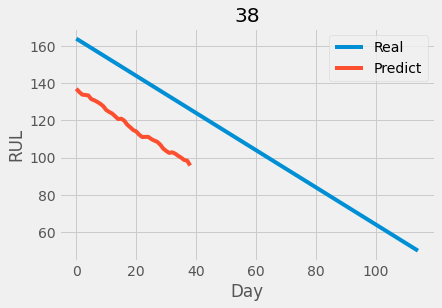

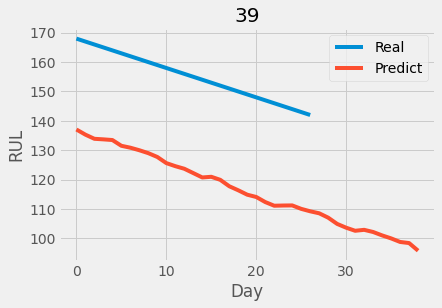

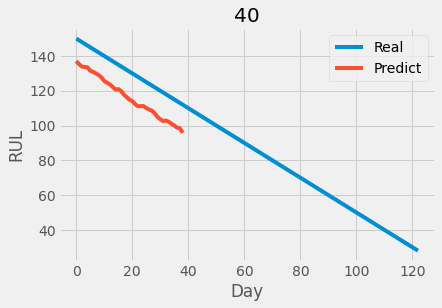

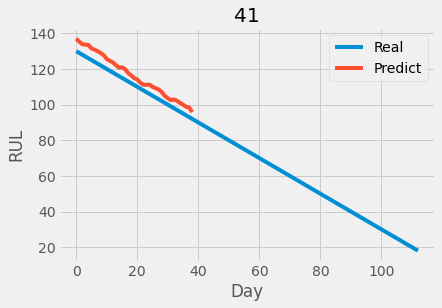

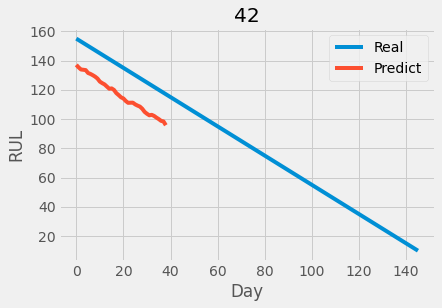

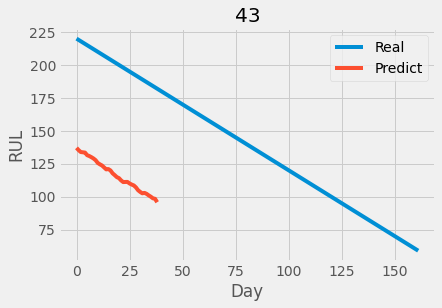

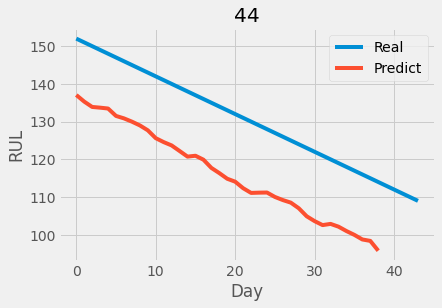

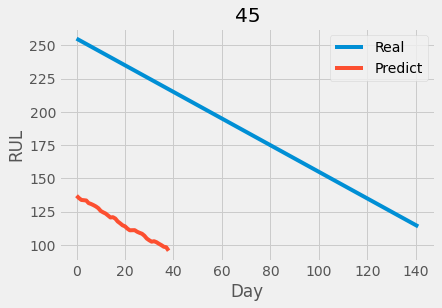

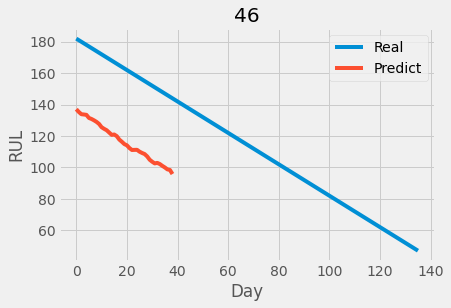

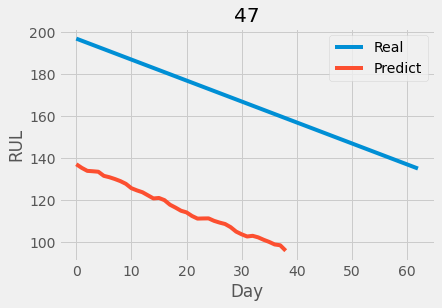

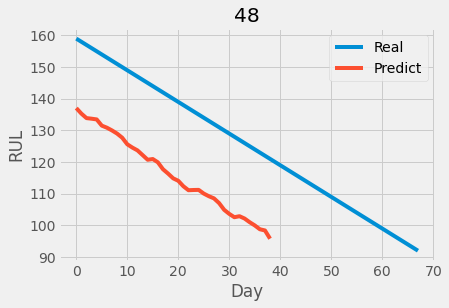

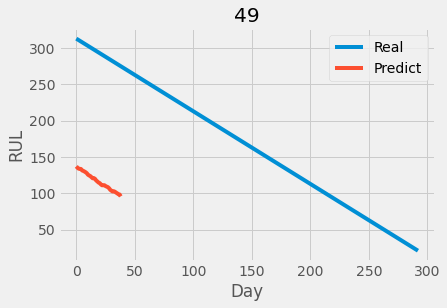

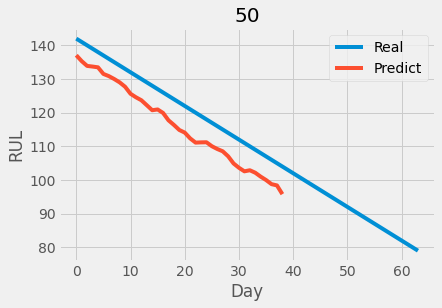

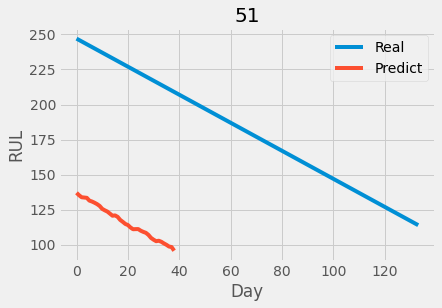

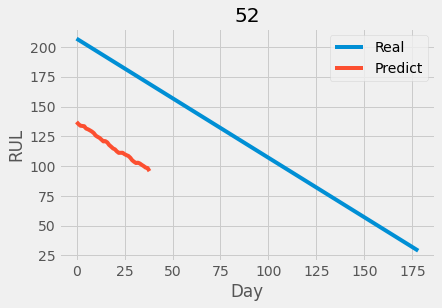

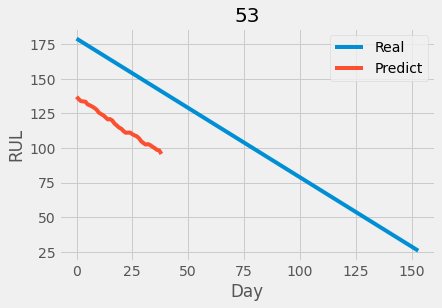

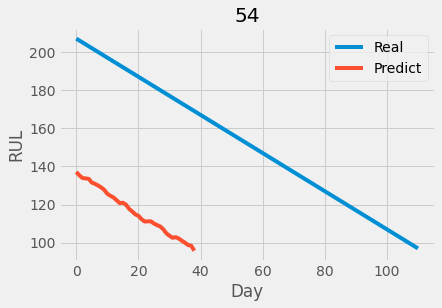

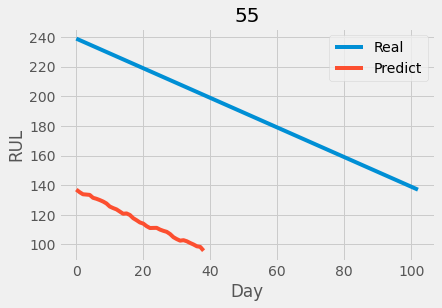

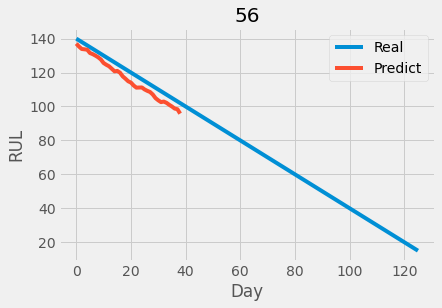

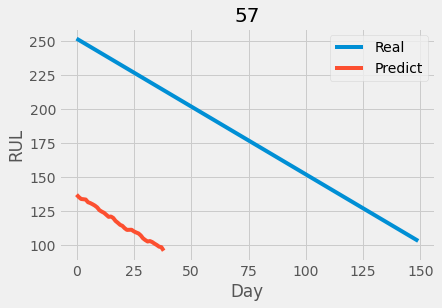

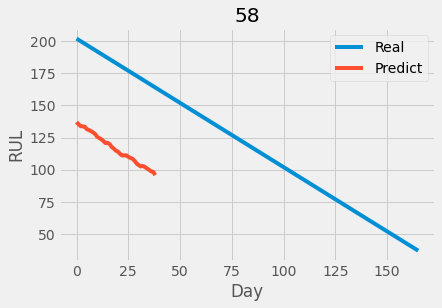

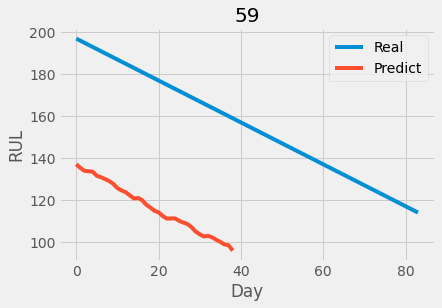

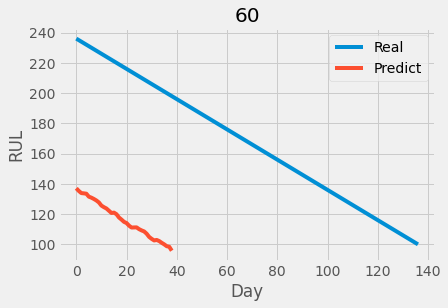

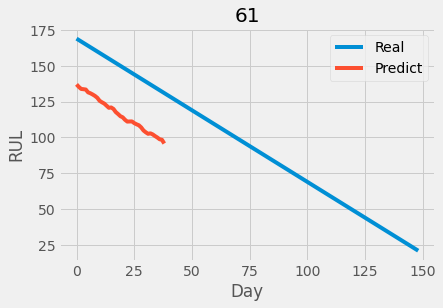

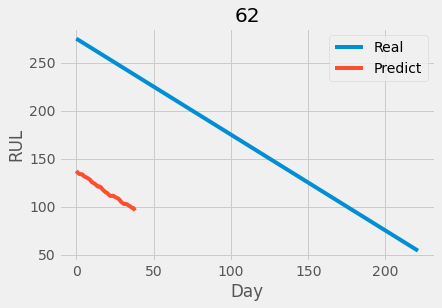

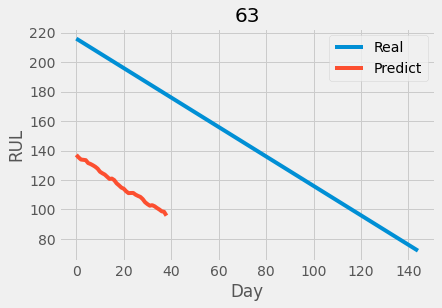

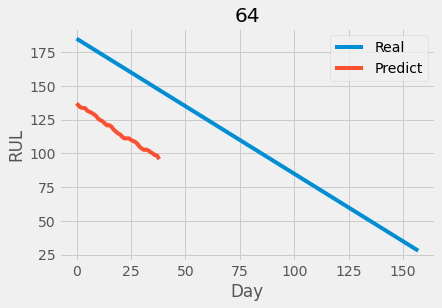

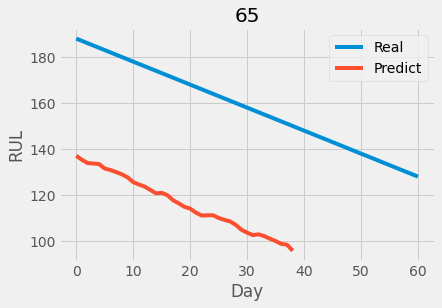

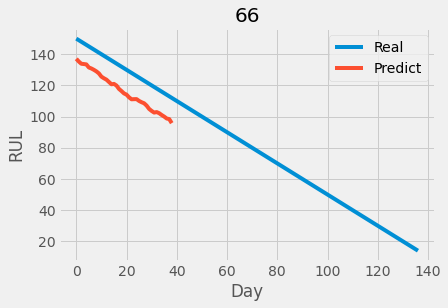

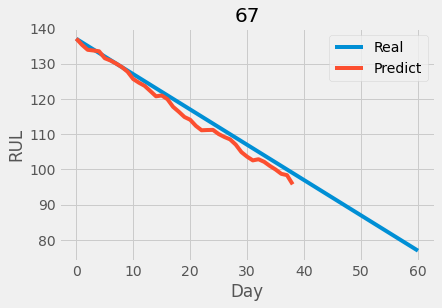

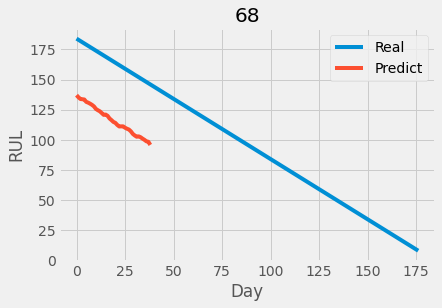

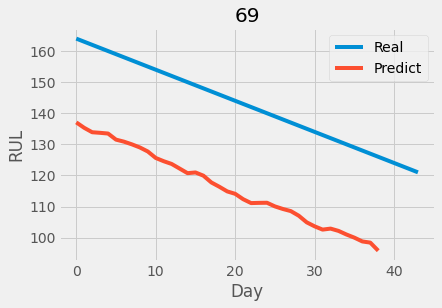

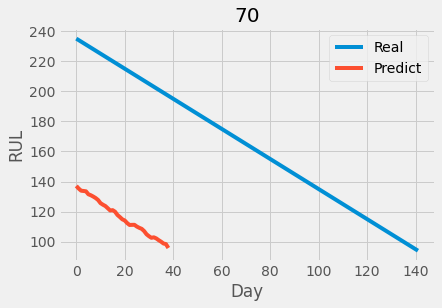

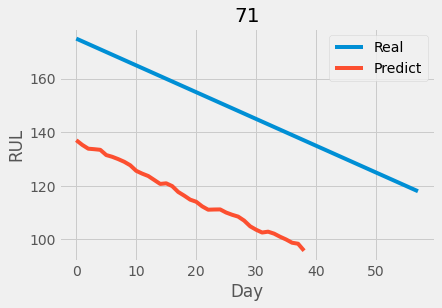

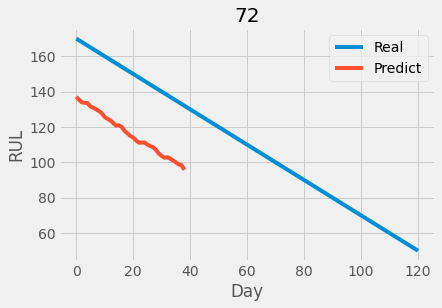

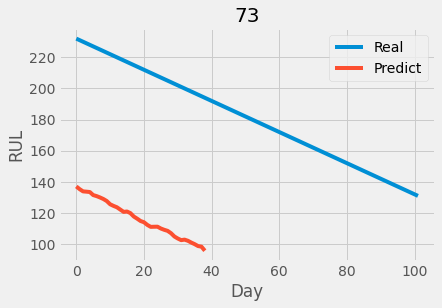

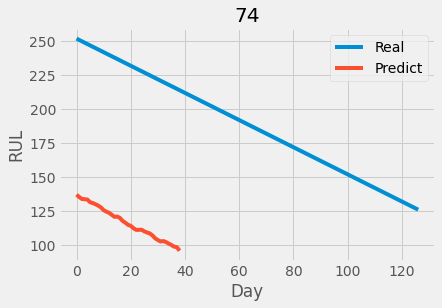

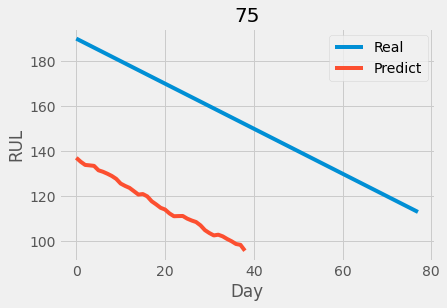

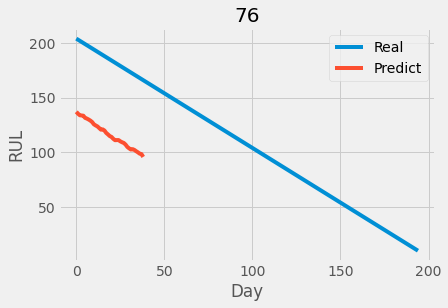

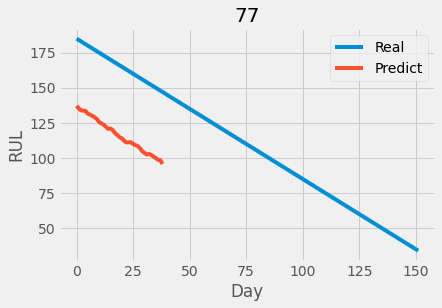

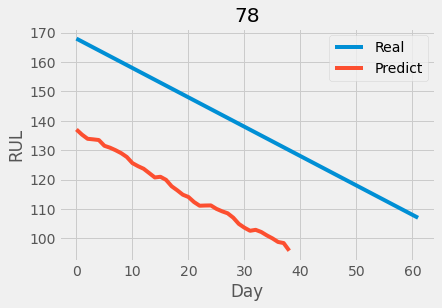

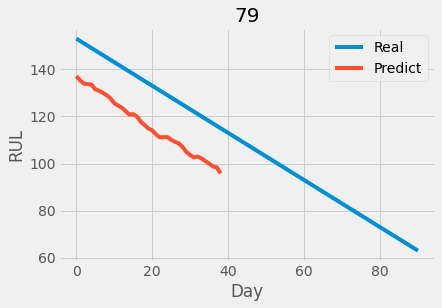

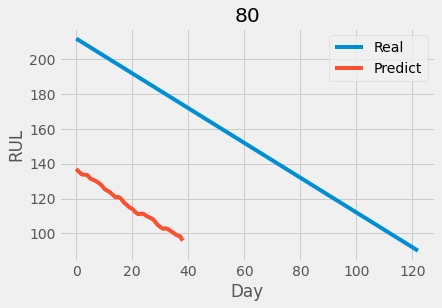

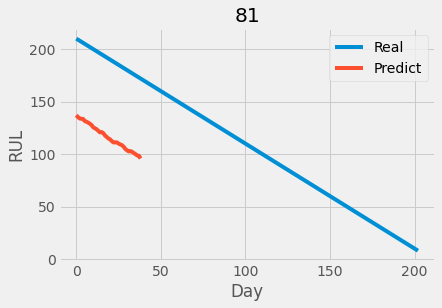

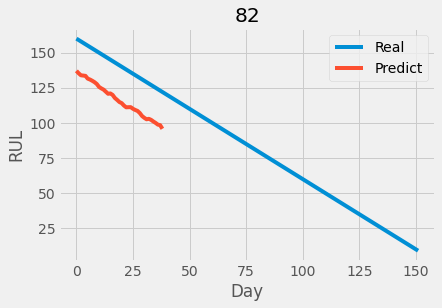

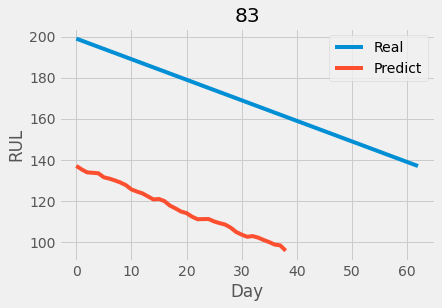

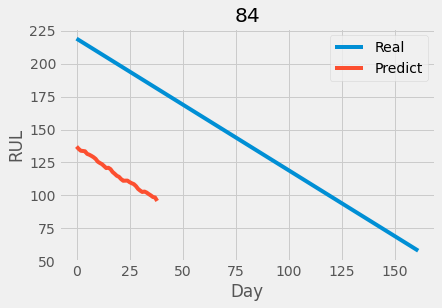

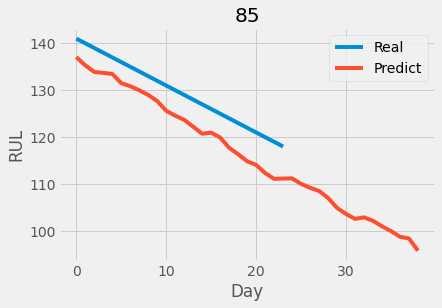

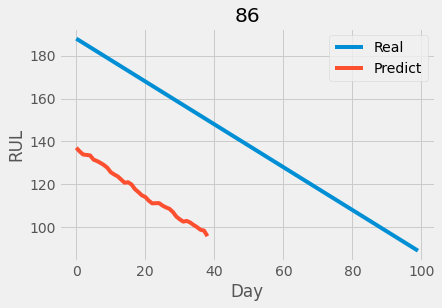

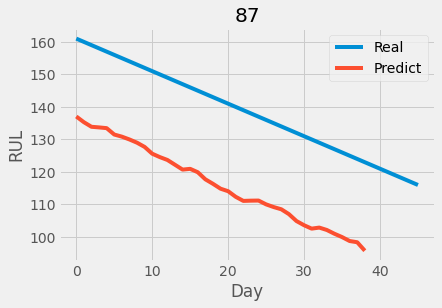

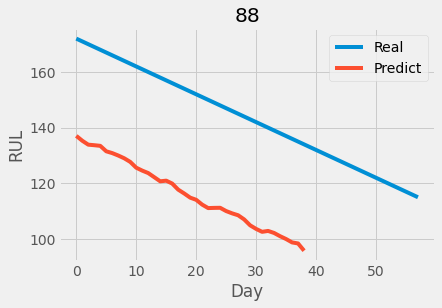

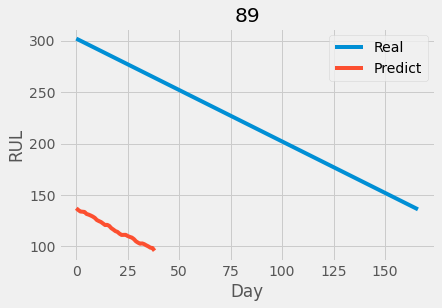

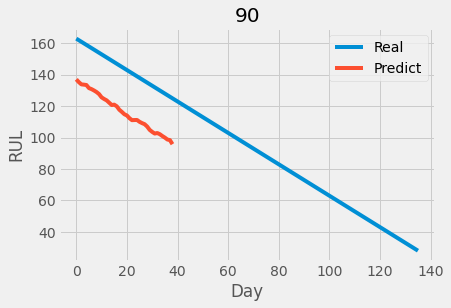

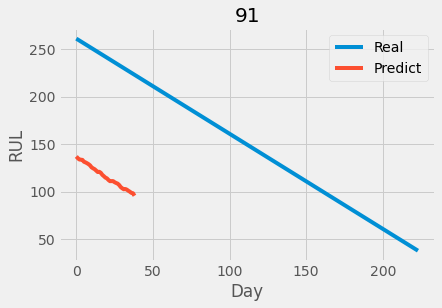

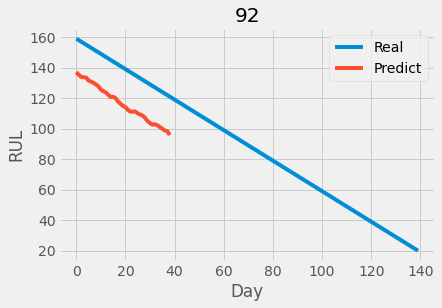

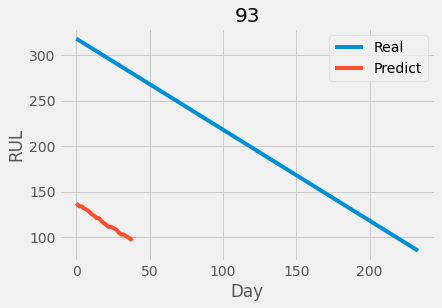

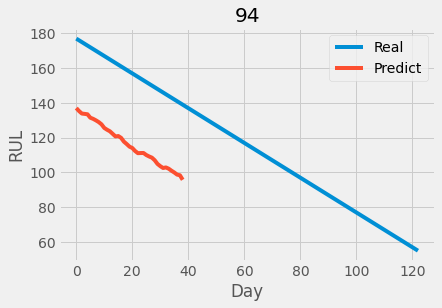

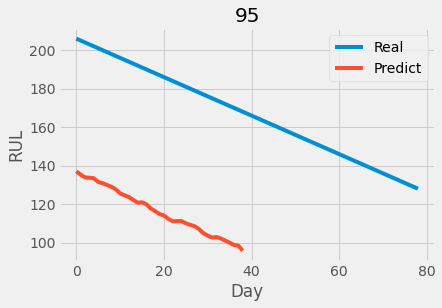

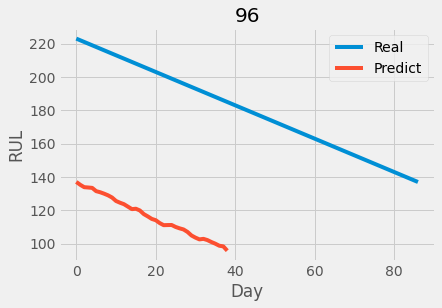

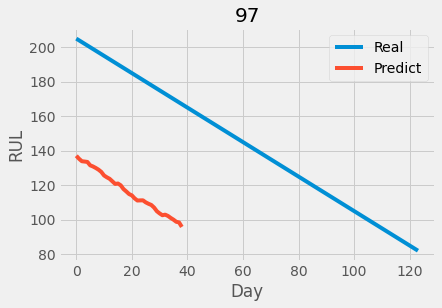

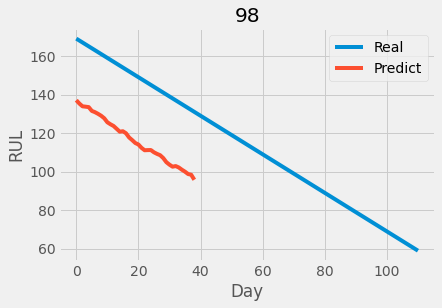

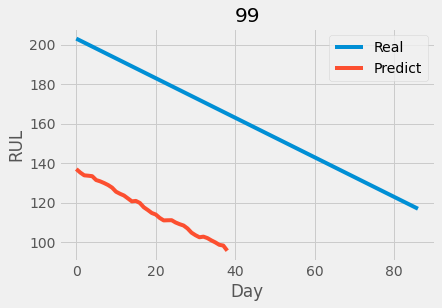

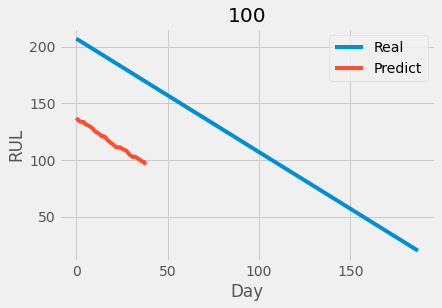

In [377]:
for i in range(1,101):
    LSTM_Plot(machine_id=i)

# GRU Network

In [39]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import keras 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [40]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=100, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer="adam",loss='mae')

In [41]:
print(regressorGRU.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 10, 100)           35700     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 96,401
Trainable params: 96,401
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/55
287/287 - 9s - loss: 85.2719 - val_loss: 102.5767
Epoch 2/55
287/287 - 6s - loss: 63.4869 - val_loss: 79.4698
Epoch 3/55
287/287 - 6s - loss: 47.9225 - val_loss: 60.9333
Epoch 4/55
287/287 - 6s - loss: 36.6321 - val_loss: 46.2677
Epoch 5/55
287/287 - 6s - loss: 28.1912 - val_loss: 35.0036
Epoch 6/55
287/287 - 6s - loss: 22.0590 - val_loss: 27.9586
Epoch 7/55
287/287 - 7s - loss: 17.9792 - val_loss: 21.9011
Epoch 8/55
287/287 - 7s - loss: 14.9361 - val_loss: 18.8917
Epoch 9/55
287/287 - 7s - loss: 12.9390 - val_loss: 15.2073
Epoch 10/55
287/287 - 7s - loss: 11.4357 - val_loss: 13.4212
Epoch 11/55
287/287 - 7s - loss: 10.4462 - val_loss: 12.5267
Epoch 12/55
287/287 - 6s - loss: 9.7113 - val_loss: 12.6357
Epoch 13/55
287/287 - 7s - loss: 9.9580 - val_loss: 9.7660
Epoch 14/55
287/287 - 6s - loss: 8.5881 - val_loss: 9.8655
Epoch 15/55
287/287 - 6s - loss: 8.0487 - val_loss: 10.4521
Epoch 16/55
287/287 - 6s - loss: 8.0720 - val_loss: 9.4971
Epoch 17/55
287/287 - 6s - loss: 7.6544 

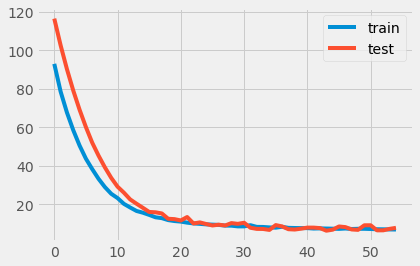

In [44]:
# Fitting to the training set
regressorGRU.fit(train_X, train_y,epochs=55,batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [66]:
def GRU_RUL_RMSE(machine_id):
    machine_df=dataset_test[dataset_test.id==machine_id]
    leakage_to_drop = ['id', 'cycle', 'setting3']  
    test_no_leakage = machine_df.drop(leakage_to_drop, axis = 1)
    vars_to_drop = ["s"+str(i) for i in [6, 16, 5, 18, 19, 1, 10]]
    test_final = test_no_leakage.drop(vars_to_drop, axis = 1)
    test_final_name =test_final.columns
    test_final_name = test_final_name.drop("RUL")
    sc_test=MinMaxScaler()
    test_final[train_final_name]=sc_test.fit_transform(test_final[test_final_name]) 
    cols_change_test = test_final.columns.tolist()
    cols_change_test =['RUL', 'setting1', 'setting2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17','s20','s21']
    test_final = test_final[cols_change_test]
    # specify the number of lag hours
    n_priod =10
    n_features = 17
    reframed_test = series_to_supervised(test_final, n_priod, 1)
    values_test = reframed_test.values
    # split into input and outputs
    n_obs = n_priod * n_features
    test_X, test_y = values_test[:, :n_obs], values_test[:, -n_features]
    test_X = test_X.reshape((test_X.shape[0], n_priod, n_features))
    # make a prediction
    yhat = regressorGRU.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_priod*n_features))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, -16:]), axis=1)
    inv_yhat = inv_yhat[:,0]
    RUL_prid = inv_yhat[-1]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -16:]), axis=1)
    inv_y = inv_y[:,0]
    RUL_truth = inv_y[-1]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    return RUL_prid, RUL_truth , rmse

In [67]:
GRU_RUL_RMSE(12)

(123.54185485839844, 124.0, 15.151016196202264)

In [68]:
RUL_prid_GRU =list()
for i in range(1,101):
    RUL_prid_GRU.append(GRU_RUL_RMSE(machine_id = i))

In [69]:
RUL_prid_GRU = DataFrame(RUL_prid_GRU,columns=['RUL_prid_GRU', "RUL_truth_GRU", "rmse_GRU"] )
RUL_prid_GRU.index += 1
RUL_prid_GRU

RUL_prid_GRU  RUL_truth_GRU   rmse_GRU
1      112.594193          112.0   0.962944
2       97.045258           98.0   1.175480
3       68.061150           69.0   1.313543
4       80.341110           82.0   1.284806
5       91.636086           91.0   1.127057
6       93.924049           93.0   1.834300
7       90.841118           91.0   8.714593
8       93.632355           95.0   7.099100
9      112.361557          111.0   2.860902
10      94.819412           96.0  10.602599
11      96.081108           97.0   1.542308
12     123.541855          124.0  15.151016
13      93.352295           95.0   9.784490
14     106.761986          107.0   1.236223
15      82.156013           83.0   1.057042
16      82.798302           84.0   2.119915
17      48.564568           50.0   4.761504
18      28.043558           28.0   0.680608
19      85.463661           87.0   3.857319
20      14.341064           16.0   1.912770
21      56.306751           57.0   3.335826
22     111.951782          111.0   1.684435
23     113.097610          113.0   6.561585
24      17.978271           20.0   3.970774
25     144.661880          145.0   2.263268
26     118.347656          119.0   2.812783
27      65.161652           66.0   2.429297
28      95.667747           97.0   8.912139
29      88.313286           90.0   8.510998
30     113.525734          115.0   8.076155
31       5.505548            8.0   2.307503
32      47.010094           48.0   2.586068
33     105.837112          106.0   0.975131
34       5.344171            7.0   1.848548
35       8.151634           11.0   3.296044
36      16.944492           19.0   0.986243
37      19.778980           21.0   1.022484
38      48.508396           50.0   1.455733
39     143.815506          142.0   1.270061
40      25.683077           28.0   1.205688
41      16.151527           18.0   0.803027
42       8.288943           10.0   0.873889
43      57.385906           59.0   5.140197
44     110.672958          109.0   2.649251
45     114.209259          114.0   9.522847
46      45.328857           47.0   2.741708
47     135.900055          135.0   3.400713
48      90.927925           92.0   0.969095
49      19.948149           21.0   9.194641
50      77.867859           79.0   1.041093
51     114.029297          114.0   8.609618
52      27.938982           29.0   4.033199
53      24.867760           26.0   2.817647
54      97.349808           97.0   4.353115
55     135.686768          137.0   9.640495
56      13.974262           15.0   1.041064
57     102.735771          103.0   8.682211
58      35.303711           37.0   3.294681
59     112.687973          114.0   3.766858
60     100.447121          100.0   7.102409
61      19.230108           21.0   1.910529
62      53.396599           54.0  10.688079
63      71.981834           72.0   4.517380
64      27.478445           28.0   1.634991
65     127.146362          128.0   2.101644
66      11.644133           14.0   2.397703
67      77.029976           77.0   0.918634
68       5.810970            8.0   2.779989
69     122.079132          121.0   1.126341
70      93.294785           94.0   7.604877
71     116.943756          118.0   1.267979
72      48.438713           50.0   1.307186
73     130.632172          131.0   7.864170
74     126.592583          126.0   9.897324
75     114.042084          113.0   3.367741
76       7.109573           10.0   4.287644
77      33.438686           34.0   1.936834
78     106.767059          107.0   1.336964
79      63.611019           63.0   1.110094
80      89.036209           90.0   4.461569
81       5.688240            8.0   4.110320
82       7.044822            9.0   0.817206
83     137.021835          137.0   3.913155
84      58.684776           58.0   5.066748
85     118.196487          118.0   1.021842
86      88.608688           89.0   2.396423
87     116.491531          116.0   2.051086
88     116.098572          115.0   1.529958
89     135.733780          136.0  11.456769
90      26.101620           28.0   1.895241
9